<a href="https://colab.research.google.com/github/AntonAIG/cvr_data_analytics/blob/main/reports/cvrf_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction 
This analysis focuses on identifying the relationships between voltage reduction and changes in power demand. Conservation Voltage Reduction (CVR) factor is the ratio between percentage change in voltage and a percentage change in power.
The objective of this report is to determine the CVR factor from the given datasets, and understand the relationships and correlations that exist between the parameters.
In other to estimate the benefits of CVR, an evaluation of the measurement results obtained from our testing sites will be carried out so that we can be able to answer the following scientific questions:
*   How much power can be saved by implementing CVR?
* When is the period of peak power?

### Table of Contents
* Importing packages
* Importing datasets
* Tap change detection algorithm
* Voltage and power analysis
* CVR factor computation
* Visualizations
* Conclusion

## Importing packages
The packages for this evaluation are standard python libraries such as `numpy`, `pandas`, `matplotlib`, etc

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline

In [3]:
#CONSTANTS
WINDOW = 6

## Importing datasets
The monthly datasets will be imported here, from January to December

The monthly values were cleaned and joined in `sql` GCP: BigQuery. Check the sql script [here](https://github.com/AntonAIG/cvr_data_analytics/blob/main/sql_script/sql_ront_2020_union.sql)

In [33]:
ront_df = pd.read_csv("/content/drive/MyDrive/bq-results-20220201/ront_2020_all.csv",
                      parse_dates=True, index_col='timestamp')
ront_df.head()

,P_1,U_1_RMS
timestamp,,
2020-01-01 00:00:00+00:00,27.274170,229.295000
2020-01-01 00:00:00+00:00,27.291255,229.488750
2020-01-01 00:00:00+00:00,27.159150,229.195625
2020-01-01 00:00:00+00:00,32.075200,229.608125
2020-01-01 00:00:00+00:00,27.058585,229.116250


In [34]:
# create a list of all the parameters: P and U
P = ront_df['P_1']
U = ront_df['U_1_RMS']
t = ront_df.index

### Summary statistics
A closer look at the data shows can be performed as follows:

In [35]:
## pandas summary
ront_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2826953 entries, 2020-01-01 00:00:00+00:00 to 2020-12-31 23:59:00+00:00
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   P_1      float64
 1   U_1_RMS  float64
dtypes: float64(2)
memory usage: 64.7 MB


In [36]:
# average value of voltage changes
ront_df.describe()

,P_1,U_1_RMS
count,2.826953e+06,2.826953e+06
mean,1.157283e+01,2.266446e+02
std,1.111502e+01,2.162906e+00
min,-3.403899e+01,0.000000e+00
25%,5.462815e+00,2.249944e+02
50%,1.210604e+01,2.271208e+02
75%,1.895172e+01,2.282273e+02
max,5.963310e+01,2.368262e+02


The table above shows that:
* The average voltage level is at 226.64V, this value is within the expected interval for the German distribution network.
* The maximum voltage value is within the +10% voltage threshold for a distribution network. Thus, there are no upper threshold voltage violations.
* The lower voltage band is at 0 while the expected limit is -10% of 226.64V
Therefore, we have to filter out the data points that didn't meet up with this limit

In [37]:
violation_index = []
for i in range(len(U)):
  if U[i] < (226.64 - (226.64*0.1)):
    violation_index.append(i)
  else:
    i+=1

In [38]:
print(ront_df.iloc[violation_index])

                                P_1  U_1_RMS
timestamp                                   
2020-06-10 12:08:00+00:00  11.95752      0.0


There was only one violation at the time shown above. We can delete this time in the dataframe

In [39]:
ront_df.drop(index=ront_df.iloc[violation_index].index.tolist(), inplace=True)

Function below extracts the hours for each datetime so that we can create time-of-day (**TOD**) groups. This is neccessary because we want to find out the CVR factors in various TOD. They are partitioned as follows:
* tg1 = 16:00 - 22:00
* tg2 = 22:00 - 04:00
* tg3 = 04:00 - 10:00
* tg4 = 10:00 - 16:00

The solar yield in tg4 is the most, therefore we want to isolate its impact on the CVR factor estimation. This is because load demand reduction during this period will always be influenced by PV production.

In [40]:
def n_time(index):
    date_time = t[index]
    hr = date_time.hour
    return hr

## Tap Change detection algorithm
A tap change occures when the voltage difference between two points is more than 1.7%. For a nominal voltage setpoint of 230V, this evaluates to 4V.
as shown bellow:

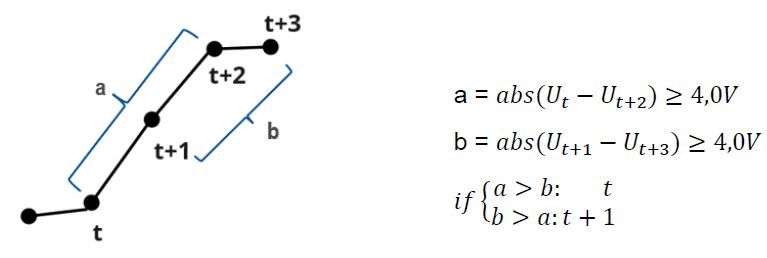

In [41]:
# calculating dV for the entire day
def delta_v_index(vlist):
    
    delta_index = []
    for i in range(len(vlist)-3):
        a = abs(vlist[i] - vlist[i+2])
        b = abs(vlist[i+1] - vlist[i+3])
        if a > 4 or b > 4:
            if a > b:
                delta_index.append(i)
            else:
                delta_index.append(i+1)
#         elif a > 4 and b < 4:
#             delta_index.append(i)
        else:
            i+=1
    
    return delta_index

We can parse the voltage measurements into the `delta_v_index()` function and group by TOD

In [42]:
def combined_index(alist):
    a = set(alist)
    index = list(a)
    remove_index = []
    
    for i in range(len(index)-1):
        if index[i] == index[i+1]:
            remove_index.append(i+1)
        else:
            i+=1
    for k in range(len(index)-1):
        ch =  abs(index[k] - index[k+1])
        if ch < 7:
            remove_index.append(k+1)
        else:
            k+=1
    for j in sorted(remove_index, reverse=True):
        del index[j]
    
    return index

In [91]:
dU = delta_v_index(U)
com_index = sorted(combined_index(dU), reverse=False)
TG1 = []
TG2 = []
TG3 = []
TG4 = []
for d in com_index:
    h = n_time(d)
    if h>22 or h<4:
        TG2.append(d)
    elif h>4 and h<10:
        TG3.append(d)
    elif h>10 and h<16:
        TG4.append(d)
    else:
        TG1.append(d)

#print('TG1= {} \nTG2= {} \nTG3= {} \nTG4= {}'.format(TG1, TG2, TG3, TG4))

The time groups above represent the timestamps where a tap change originates from.

## Voltage and power analysis

Using the tap positions (timestamps) detected from above, we can further evaluate the `%dU` and `%dP` values called percentage change in voltage and percentage change in active power respectively.

Using a mean absolute diviation (MAD) method, we can create an interval of voltage and power before and 2 steps after the tap change origin, and find the mean of both intervals.

In [44]:
# voltage change
def delta_u(tod):
    GAP = tod + 2
    st = tod - WINDOW #as defined above (value=6)
    fn = GAP + WINDOW
    
    bf_int = U[st:tod]
    aft_int = U[GAP:fn]
    
    u1 = np.mean(bf_int)
    u2 = np.mean(aft_int)
    pdu = ((u1-u2)/u1)*100
    
    return pdu

In [45]:
# power change
def delta_p(tod):
    GAP = tod + 2
    st = tod - WINDOW
    fn = GAP + WINDOW
    
    bf_int = P[st:tod]
    aft_int = P[GAP:fn]
    
    p1 = np.mean(bf_int)
    p2 = np.mean(aft_int)
    ch = p1 - p2
    if p1 < 0:
        pdp = (ch/abs(p1))*100
    else:
        pdp = (ch/p1)*100
    
    return pdp

## CVR factor computation
CVR factor is the ratio between `%dP` and `%dU` obtained from the previous section
This ratio defines the impact of voltage reduction on power consumption. For example, a CVRf of 0.75 implies that a 1% change in voltage results to a 0.75% change in active power

In [46]:
def cvrf_p(tod):
    
    volt = delta_u(tod)
    powr = delta_p(tod)
    cvr = powr/volt
    
    return cvr

In [47]:
def cvr_eval(tg):
  cvr_val = []
  for i in tg:
    cvr = cvrf_p(i)
    cvr_val.append(round(cvr, 4))
#     cvrq = cvrf_q(dd,i)
#     cvrQ_points.append(cvrq)
  return cvr_val

In [49]:
# filter outliers at +- 10
def cvr_filter(ppoints):
    fp = []
    for j in ppoints:
        if j > -10 and j < 10:
            fp.append(j)
    return fp

In [50]:
cvr_tg1 = cvr_filter(cvr_eval(TG1))
cvr_tg2 = cvr_filter(cvr_eval(TG2))
cvr_tg3 = cvr_filter(cvr_eval(TG3))
cvr_tg4 = cvr_filter(cvr_eval(TG4))

## Visualizations
The values of the CVRf as computed are contained in `cvr_tg1`, `cvr_tg2`, `cvr_tg3`, and `cvr_tg4`. Next, we can determine the mean and median values of CVRf for each time group and plot in a box plot.


### Mean CVR factors

In [69]:
fig = go.Figure()
fig.add_trace(go.Box(y=cvr_tg1, boxmean=True, boxpoints='outliers', name='16:00 - 22:00'))
fig.add_trace(go.Box(y=cvr_tg2, boxmean=True, boxpoints='outliers', name='22:00 - 04:00'))
fig.add_trace(go.Box(y=cvr_tg3, boxmean=True, boxpoints='outliers', name='04:00 - 10:00'))
fig.add_trace(go.Box(y=cvr_tg4, boxmean=True, boxpoints='outliers', name='10:00 - 16:00'))
fig.show()

The CVR factors shown above falls within the range of 0.65 - 1.5 as expected. Group 1 has the highest CVRf values at 0.97 as expected. This implies that the evening period (peak power consumption) will provide the highest CVR benefits. Thus 1% reduction in voltage will result in approx. 1% reduction in power.

### Load profile seasonality
Theoretically, there should be a seasonality in daily consumption of power accross one week. From this diagram, we wan observe the peak power consumption periods. For the month of December

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



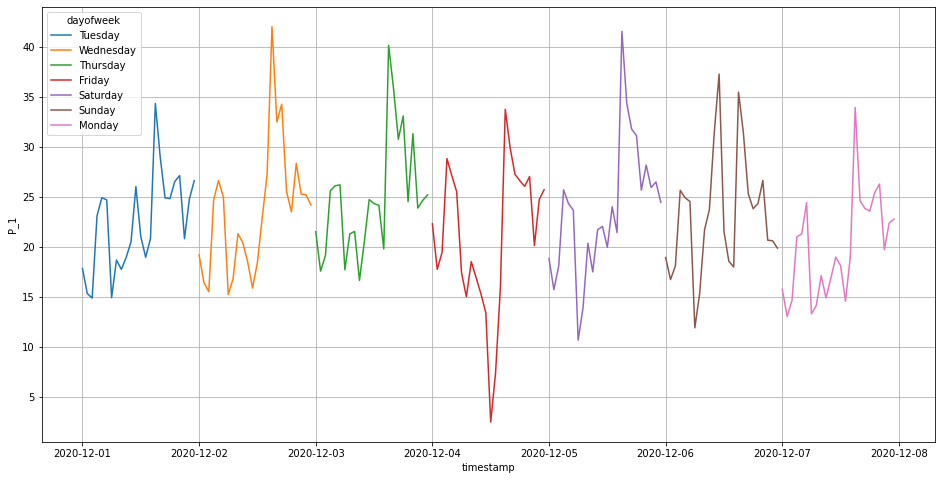

In [90]:
ront_dec = ront_df['2020-12-01 00:00:00+00:00':'2020-12-31 23:59:00+00:00']
dec_df = ront_dec.resample('H').mean()
week1 = dec_df['2020-12-01 00:00:00+00:00':'2020-12-07 23:59:00+00:00']
week1['dayofweek'] = week1.index.day_name()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=week1.index, y='P_1', hue='dayofweek', data=week1)
ax.grid()